Version 1 of data cleaning and feature engineering.

This version is to ensure that I have a working version of the data which I can use to build and assess classification models.

The general goal is to create a dataset which contains: 

* student biographical information (student table)
* student's course registration information (course and registration tables)
* student's assessment information (assessments table)
  * this needs to be feature engineered to create a single row per student per course
  * as each module has a different number of assessments, this dataset will engineer features which are available for all modules (i.e. average score, proportion of assessments submitted, mean distance from due date, etc.)
* student's VLE information (VLE table)
  * this needs to be feature engineered to create a single row per student per course
  * as each module has a different number of VLE interactions, this dataset will engineer features which are available for all modules (i.e. average number of clicks, proportion of clicks on each resource type, etc.)

Finally, the dataset needs to be sliced in relation to the prediction point:
* students who have withdrawn at the point of prediction need to be excluded - as their outcome is known and will only confuse the model
* more critically, a mechanism to remove assessments, vles, etc. which have 'not 'happened in relation to the prediction point needs to be implemented.  
* this will be the enhanced version - or a future version - of the dataset which will:
  * allow for the prediction of the outcome at any point in the course
  * comparison between time periods


Future versions/questions/scnenarios to explore:

* predict at any point in the course, with information available up to that point
* comparisons between modules - that is, different models per module
* do different models perform better at different points in the course?
* is biographical information useful?
* are there inherent student characteristics which are predictive of outcome?
* are there clusters (unsupervised learning) of students which are predictive of outcome?
* can a model be built which incorporates previous predictions into the model?

BUT - for this assignment, I need to first have something which works and fulfills the assignment specification.



## Data preparation

### Libraries and zip file

In [6]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt


In [18]:
    
# import zip file with csv 
ou_zip = zipfile.ZipFile('../data/anonymisedData.zip') 

# save separate csvs
registrations = pd.read_csv(ou_zip.open('studentRegistration.csv'))
courses = pd.read_csv(ou_zip.open('courses.csv'))
students = pd.read_csv(ou_zip.open('studentInfo.csv'))
student_vle = pd.read_csv(ou_zip.open('studentVle.csv'))
vle = pd.read_csv(ou_zip.open('vle.csv'))
student_assessments = pd.read_csv(ou_zip.open('studentAssessment.csv'))
assessments = pd.read_csv(ou_zip.open('assessments.csv'))

### student information

* base table to which all other tables will be joined



TODO remove rows (students) with missing data in imd_cat


In [19]:
students.count()


code_module             32593
code_presentation       32593
id_student              32593
gender                  32593
region                  32593
highest_education       32593
imd_band                31482
age_band                32593
num_of_prev_attempts    32593
studied_credits         32593
disability              32593
final_result            32593
dtype: int64

### course information
* add course information from course table - merge on code_module and code_presentation
* TODO create new features for 'intake', 'year' and 'subject'


In [32]:
# merge students and courses
final = pd.merge(students, courses, on=['code_module', 'code_presentation'], validate='many_to_one')

final.count()

code_module                   32593
code_presentation             32593
id_student                    32593
gender                        32593
region                        32593
highest_education             32593
imd_band                      31482
age_band                      32593
num_of_prev_attempts          32593
studied_credits               32593
disability                    32593
final_result                  32593
module_presentation_length    32593
dtype: int64

### registrations

* merge registration table with student table


In [33]:
# merge registrations
final = pd.merge(final, registrations, on=['code_module', 'code_presentation', 'id_student'], how = 'left', validate='1:1')
final.count()

code_module                   32593
code_presentation             32593
id_student                    32593
gender                        32593
region                        32593
highest_education             32593
imd_band                      31482
age_band                      32593
num_of_prev_attempts          32593
studied_credits               32593
disability                    32593
final_result                  32593
module_presentation_length    32593
date_registration             32548
date_unregistration           10072
dtype: int64

In [34]:
# drop missing value rows (date_registration, imd_band)
final.dropna(subset=['date_registration', 'imd_band'], inplace=True)
final.count()

code_module                   31437
code_presentation             31437
id_student                    31437
gender                        31437
region                        31437
highest_education             31437
imd_band                      31437
age_band                      31437
num_of_prev_attempts          31437
studied_credits               31437
disability                    31437
final_result                  31437
module_presentation_length    31437
date_registration             31437
date_unregistration            9798
dtype: int64

In [35]:
final['final_result'].unique()

array(['Pass', 'Withdrawn', 'Fail', 'Distinction'], dtype=object)

In [64]:
# prediction point = days from start of course
prediction_point = 200

# prediction point must be less than course length, integer, and greater than 0
if not isinstance(prediction_point, int) or prediction_point <= 0 or prediction_point >= max(final['module_presentation_length']):
    print("Error: Invalid prediction point. \n\nPlease provide an integer value greater than 0 and less than the maximum course length. \n\nThis is the number of days from the start of the course for which you want to predict the outcome.")
else:
    # withdrawn or failed before prediction point - remove
    withdrawn_fail_condition = (final['final_result'].isin(['Withdrawn', 'Fail'])) & (final['date_unregistration'] <= prediction_point)
    final.loc[withdrawn_fail_condition, 'status'] = 'remove_outcome_known'
    # if unregister after prediction point - keep
    unregister_after_condition = final['date_unregistration'] > prediction_point
    final.loc[unregister_after_condition, 'status'] = 'keep'
    # if no unregistration date - keep
    no_unregistration_condition = final['date_unregistration'].isna()
    final.loc[no_unregistration_condition, 'status'] = 'keep'
    # default case
    final.loc[~(withdrawn_fail_condition | unregister_after_condition | no_unregistration_condition), 'status'] = 'query'






In [87]:
# check if any weird results
query_rows = final[final['status'] == 'query'] | final[final['status'].isna()]
print(query_rows)


Empty DataFrame
Columns: [code_module, code_presentation, id_student, gender, region, highest_education, imd_band, age_band, num_of_prev_attempts, studied_credits, disability, final_result, module_presentation_length, date_registration, date_unregistration, status]
Index: []


following the above steps, the missing values in date_unregistration should be populated with the max of the course end date, for now...



In [66]:
# replace missing date_unreg with module_presentation_length
final['date_unregistration'] = final['date_unregistration'].fillna(final['module_presentation_length'])
final.count()

code_module                   31437
code_presentation             31437
id_student                    31437
gender                        31437
region                        31437
highest_education             31437
imd_band                      31437
age_band                      31437
num_of_prev_attempts          31437
studied_credits               31437
disability                    31437
final_result                  31437
module_presentation_length    31437
date_registration             31437
date_unregistration           31437
status                        31437
dtype: int64

now the table to use can be created by filtering on status which takes into account the prediction point, if there is one....

need a default value - maybe max of course end date?

In [70]:
model_final = final[final['status'] != 'remove_outcome_known']
model_final.count()
#model_final.head(20)

code_module                   22149
code_presentation             22149
id_student                    22149
gender                        22149
region                        22149
highest_education             22149
imd_band                      22149
age_band                      22149
num_of_prev_attempts          22149
studied_credits               22149
disability                    22149
final_result                  22149
module_presentation_length    22149
date_registration             22149
date_unregistration           22149
status                        22149
dtype: int64

### assessments

* prep assessments table first
* merge assessments table with student table
* 

In [158]:
# merge 'assessments' and 'courses' on 'code_module' and 'code_presentation'
course_assess = assessments.merge(courses[['code_module', 'code_presentation', 'module_presentation_length']], on=['code_module', 'code_presentation'], how='left')

# fill in the missing 'date' values with course final week (as per literature)
value_to_fill = course_assess['module_presentation_length'] - 3
course_assess['date'] = course_assess['date'].fillna(value_to_fill)

In [159]:
course_assess.count()
#student_assessments.count()

code_module                   206
code_presentation             206
id_assessment                 206
assessment_type               206
date                          206
weight                        206
module_presentation_length    206
dtype: int64

In [160]:
merged_assess = pd.merge(student_assessments, course_assess, on=['id_assessment'], how='left')

In [161]:
missing_values = merged_assess.isnull().sum()
print("Missing values:\n", missing_values, "\n")

Missing values:
 id_assessment                   0
id_student                      0
date_submitted                  0
is_banked                       0
score                         173
code_module                     0
code_presentation               0
assessment_type                 0
date                            0
weight                          0
module_presentation_length      0
dtype: int64 



In [162]:

missing_score_rows = merged_assess[merged_assess['score'].isna()]
print(missing_score_rows)

print(missing_score_rows['id_student'].nunique())
missing_score_rows['id_student'].unique()

        id_assessment  id_student  date_submitted  is_banked  score  \
215              1752      721259              22          0    NaN   
937              1754      260355             127          0    NaN   
2364             1760     2606802             180          0    NaN   
3358            14984      186780              77          0    NaN   
3914            14984      531205              26          0    NaN   
...               ...         ...             ...        ...    ...   
148929          34903      582670             241          0    NaN   
159251          37415      610738              87          0    NaN   
166390          37427      631786             221          0    NaN   
169725          37435      648110              62          0    NaN   
170103          37435      480914              49          0    NaN   

       code_module code_presentation assessment_type   date  weight  \
215            AAA             2013J             TMA   19.0    10.0   
937  

array([ 721259,  260355, 2606802,  186780,  531205,  534151,  549713,
        554393,   33666,  511527,  554818,  484039,  262294,  478317,
        502717,  515497,  501208,  308703,  342685,  420724,  507279,
        525877,  242893,  583473,  476278,  352688,  606501,  260955,
        271467,  591547,  291844,  588039,  593345,  615173,  190565,
        394331,  487543,  613205,  625383,  628982,  630549,  654422,
        678578,  693871,  602448,  506679,  173163,  632722, 1723749,
        688167, 2410544,  471018,  629500,  193163,  413083,  548764,
        511350,  570671,  610537, 2500064,  546634,  572783,  168243,
        235428,  555297,  357576,  535707,  305702,  510530,  518097,
        412731,  554773,  556308,  560260,  191896,  241771,  252489,
        413934,  415695,  427248,  557247,  588293,  603498,   77241,
        571765,  607854, 2261142,  505854,  524109,  546299,  614217,
        630401,  502207,  607462,  616542,  646391,  652292,  676642,
        687765,  526

173 assessments have no score, from 160 students. 

Decision is to remove them - I don't know why they have no score; I don't have anything to impute them with and don't want to introduce bias into this dataset.

It may be legitimate information - e.g. that students with no score are more likely to withdraw, but it could be administrative error, or a data issue.  I don't know, so I'm going to remove them. 

If there has been a submission, then there ought to be a score, even if that is 0.  

I don't want to impute (0, 50, mean, median, etc.) - I think it makes things more murky.

remove rows with missing scores



In [163]:
# drop students who have no score for any assessment

unique_ids = missing_score_rows['id_student'].unique()
model_final = model_final[~model_final['id_student'].isin(unique_ids)]
model_final.count()

code_module                   21447
code_presentation             21447
id_student                    21447
gender                        21447
region                        21447
highest_education             21447
imd_band                      21447
age_band                      21447
num_of_prev_attempts          21447
studied_credits               21447
disability                    21447
final_result                  21447
module_presentation_length    21447
date_registration             21447
date_unregistration           21447
status                        21447
dtype: int64

In [164]:
# drop rows with missing score
merged_assess.dropna(subset=['score'], inplace=True)
merged_assess.count()

id_assessment                 173739
id_student                    173739
date_submitted                173739
is_banked                     173739
score                         173739
code_module                   173739
code_presentation             173739
assessment_type               173739
date                          173739
weight                        173739
module_presentation_length    173739
dtype: int64

Date Range: 12.0 to 266.0


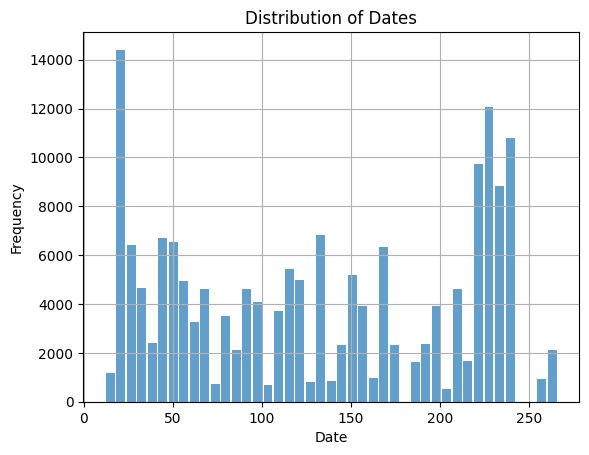

In [131]:
# assessment date range check
date_values = merged_assess['date']
print('Date Range:', date_values.min(), 'to', date_values.max())


# plotting the distribution
plt.hist(date_values, bins='auto', alpha=0.7, rwidth=0.85)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Distribution of Dates')
plt.grid(True)
plt.show()


investigate submission dates
* expecting submissions to fall within course date (0 and max of end date)
* having negative submission dates does not make sense - these will be removed, as well as the students who have made these submissions. 
* the later submission dates - will not be considered as they are outside the length of the course -> so will not be predicted on
  * it seems that module FFF has some issues with submission dates - probably a data issue, but I don't know what the correct dates should be, so I'm going to remove them.

Date Range: -11 to 608


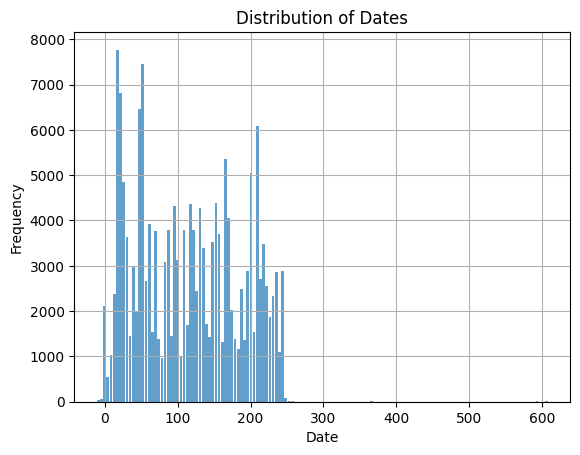

In [165]:
# assessment date range check
stu_date_values = merged_assess['date_submitted']
print('Date Range:', stu_date_values.min(), 'to', stu_date_values.max())


# plotting the distribution
plt.hist(stu_date_values, bins='auto', alpha=0.7, rwidth=0.85)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Distribution of Dates')
plt.grid(True)
plt.show()

In [166]:

greater_than_max_length = merged_assess[merged_assess['date_submitted'] > merged_assess['module_presentation_length']]
greater_than_max_length.groupby(['code_module', 'code_presentation']).count()['id_student']



code_module  code_presentation
CCC          2014B                 3
             2014J                 1
DDD          2013B                 4
             2014B                 3
             2014J                 1
FFF          2013B                25
             2013J                26
             2014B                17
             2014J                 2
Name: id_student, dtype: int64

In [ ]:
# removing students with negative or extreme date_submitted values
# removing rows from merged_assess

# get max module length
max_module_length = merged_assess['module_presentation_length'].max()

# get students with negative or extreme date_submitted values
greater_than_max_length = merged_assess[merged_assess['date_submitted'] > max_module_length]['id_student'].unique()
less_than_zero = merged_assess[merged_assess['date_submitted'] < 0]['id_student'].unique()

# remove students from model_final
students_to_remove = set(greater_than_max_length) | set(less_than_zero)
model_final = model_final[~model_final['id_student'].isin(students_to_remove)]

# remove rows from merged_assess
merged_assess = merged_assess[~merged_assess['id_student'].isin(students_to_remove)]



In [169]:

print(model_final.count())
print(merged_assess.count())

code_module                   21447
code_presentation             21447
id_student                    21447
gender                        21447
region                        21447
highest_education             21447
imd_band                      21447
age_band                      21447
num_of_prev_attempts          21447
studied_credits               21447
disability                    21447
final_result                  21447
module_presentation_length    21447
date_registration             21447
date_unregistration           21447
status                        21447
dtype: int64
id_assessment                 167942
id_student                    167942
date_submitted                167942
is_banked                     167942
score                         167942
code_module                   167942
code_presentation             167942
assessment_type               167942
date                          167942
weight                        167942
module_presentation_length    167942
dtyp

reduce dataset

reduce dataset to match 'prediction point' value - i.e. remove assessments which have not happened yet

make sure that assessment date is used, not submission date.  if submission date is used, then only students who submitted on time are included in the model - while late submission can be a feature. 



In [175]:
# reduce data by prediction point
model_student_assess = merged_assess[merged_assess['date'] <= prediction_point]

# assessment date range check
mod_date_values = model_student_assess['date']
print('Date Range:', mod_date_values.min(), 'to', mod_date_values.max())

# submission date range check
sub_date_values = model_student_assess['date_submitted']
print('Date Range:', sub_date_values.min(), 'to', sub_date_values.max())

Date Range: 12.0 to 200.0
Date Range: 0 to 240


In [172]:
model_student_assess.count()

id_assessment                 116804
id_student                    116804
date_submitted                116804
is_banked                     116804
score                         116804
code_module                   116804
code_presentation             116804
assessment_type               116804
date                          116804
weight                        116804
module_presentation_length    116804
dtype: int64

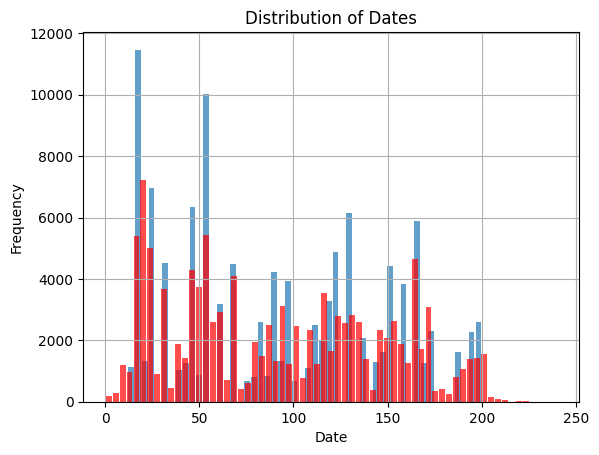

In [174]:


# plotting the distribution
plt.hist(mod_date_values, bins='auto', alpha=0.7, rwidth=0.85)
plt.hist(sub_date_values, bins='auto', alpha=0.7, rwidth=0.85, color='red')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Distribution of Dates')
plt.grid(True)
plt.show()

now - create some new features: 

* number of assessments submitted / total number of assessments expected
* average score across all assessments (expected)
* total difference between due date and submission date

In [180]:
model_course_assess.count()

code_module                   126
code_presentation             126
id_assessment                 126
assessment_type               126
date                          126
weight                        126
module_presentation_length    126
dtype: int64

In [191]:
# get expected assessment details

model_course_assess = course_assess[course_assess['date'] <= prediction_point]
#model_course_assess.count()

# expected assessment count per module_presentation
expected_ass = model_course_assess.groupby(['code_module', 'code_presentation'])['id_assessment'].count().reset_index()
expected_ass = expected_ass.rename(columns={'id_assessment': 'exp_sub_count'})

# excpeted assessment date sum
date_sum = model_course_assess.groupby(['code_module', 'code_presentation'])['date'].sum().reset_index()
expected_ass = expected_ass.merge(date_sum, on=['code_module', 'code_presentation'], how='left')
expected_ass = expected_ass.rename(columns={'date': 'exp_sub_date_sum'})

expected_ass.count()

code_module          22
code_presentation    22
exp_sub_count        22
exp_sub_date_sum     22
dtype: int64

student assessments in wide format - one row per student per course

this will be merged with model_student table

In [179]:
model_student_assess.head()
model_student_assess.count()


id_assessment                 116804
id_student                    116804
date_submitted                116804
is_banked                     116804
score                         116804
code_module                   116804
code_presentation             116804
assessment_type               116804
date                          116804
weight                        116804
module_presentation_length    116804
dtype: int64

In [190]:
student_assessment_summary = model_student_assess.groupby(['id_student', 'code_module', 'code_presentation']).agg(
    count_id_assessment=('id_assessment', 'count'),
    sum_score=('score', 'sum'),
    sum_date=('date', 'sum')
).reset_index()
student_assessment_summary.count()

id_student             24668
code_module            24668
code_presentation      24668
count_id_assessment    24668
sum_score              24668
sum_date               24668
dtype: int64

combine the tables 

In [194]:
# merge student_assessment_summary and expected_ass on code_module and code_presentation
merged_summary = student_assessment_summary.merge(expected_ass, on=['code_module', 'code_presentation'])

# calculate the new features
merged_summary['prop_submissions'] = merged_summary['count_id_assessment'] / merged_summary['exp_sub_count']
merged_summary['avg_score'] = merged_summary['sum_score'] / merged_summary['exp_sub_count']
merged_summary['submission_distance'] = merged_summary['exp_sub_date_sum'] - merged_summary['sum_date']


In [196]:
merged_summary.head(10)
merged_summary[merged_summary['prop_submissions'] != 1.0]

,id_student,code_module,code_presentation,count_id_assessment,sum_score,sum_date,exp_sub_count,exp_sub_date_sum,prop_submissions,avg_score,submission_distance
14,79403,AAA,2014J,3,182.0,190.0,4,356.0,0.75,45.50,166.0
15,85092,AAA,2014J,3,174.0,302.0,4,356.0,0.75,43.50,54.0
18,87431,AAA,2014J,3,150.0,190.0,4,356.0,0.75,37.50,166.0
19,95755,AAA,2014J,2,90.0,73.0,4,356.0,0.50,22.50,283.0
39,141506,AAA,2014J,1,75.0,19.0,4,356.0,0.25,18.75,337.0
...,...,...,...,...,...,...,...,...,...,...,...
24651,2538792,EEE,2014J,3,272.0,232.0,4,398.0,0.75,68.00,166.0
24654,2579558,EEE,2014J,1,54.0,33.0,4,398.0,0.25,13.50,365.0
24660,2637000,EEE,2014J,3,178.0,232.0,4,398.0,0.75,44.50,166.0
24665,2681277,EEE,2014J,1,95.0,33.0,4,398.0,0.25,23.75,365.0


In [202]:
duplicate_students = merged_summary[merged_summary.duplicated(subset='id_student', keep=False)]['id_student'].unique()

duplicate_rows = merged_summary[merged_summary['id_student'].isin(duplicate_students)]
duplicate_rows.sort_values('id_student')
duplicate_rows.count()

id_student             3963
code_module            3963
code_presentation      3963
count_id_assessment    3963
sum_score              3963
sum_date               3963
exp_sub_count          3963
exp_sub_date_sum       3963
prop_submissions       3963
avg_score              3963
submission_distance    3963
dtype: int64

so...it turns out that there are students who are registered on more than one module.  of course, I should have thought about this...this means that the assumption each row is independent is violated.  

I can think of a few ways to deal with this:

* remove all students who are registered on more than one module
  * this seems unfortunate, as it is a lot of data to lose

* create a model per module
  * this seems like a lot of work, and I'm not sure that it will be worth it
  * it was also part of a future version to explore

* combine id_student, code_module and code_presentation into a single id
  * this is the approach I will take, initially
  * it means that student on module intake is independent
  * this is how I imagine a distance learning student may approach their studies - i.e. focus on one module, potentially, if things are not going well. 


Remaining steps: 

* tidy merged_summary - delete unnecessary columns (keep features to be used and linking columns)
* look at vle data (do something similar to assessments)
* merge the above with the vle data
* merge vle & assessment to student data
  * merge id columns
  * drop separate columns
  * check for duplicate ids
  * check for missing values

consider putting it together into a function??!
* 

remove cols not going to use (iteration 1, weight, is_banked)



   ~~get number of assessments per course (expected number)~~
   get number of assessments perstudent row (actual number)
   get sum of scores per student row (sum actual score)
   feature = actual/expected
   feature = sum actual score/actual number * 100
   consider:
   get sum of submission dates (actual submission dates)
   ~~get sum of submission dates (expected submission dates)~~
   feature = expected submission dates - actual submission dates
   
drop unused, unneeded, columns (type, dates,etc.)
merge with final student table - left join (only active students)

In [ ]:
## to be made into a function?? with a prediction point splitter??

# step 1 merge 'student' with 'course'
final_student = pd.merge(students, courses, on=['code_module', 'code_presentation'], validate='many_to_one')
final_student.head()

# step 2 merge registrations with final_student
final_student = pd.merge(final_student, registrations, on=['code_module','code_presentation','id_student'], validate="1:1")

# step 3 drop imd_band, date_reg nulls and replace NaN for unreg date with the length of the course
final_student.dropna(subset=['date_registration', 'imd_band'], inplace=True)
final_student['date_unregistration'] = final_student['date_unregistration'].fillna(final_student['module_presentation_length'])

# step 4 drop rows where withdrew before started - may want to add cool off buffer 7-14 days? (as earlier)
final_student = final_student[final_student['date_unregistration'] < final_student['date_registration']]

# step 5 split code_presentation into year and month and add subject from code_module
final_student['year'] = final_student['code_presentation'].str[:4].astype(int)
final_student['month'] = final_student['code_presentation'].str[-1].map({'J': 'Oct', 'B': 'Feb'})

# Module subject mapping
code_module_mapping = {
    'AAA': 'SocSci',
    'BBB': 'SocSci',
    'GGG': 'SocSci',
    'CCC': 'Stem',
    'DDD': 'Stem',
    'EEE': 'Stem',
    'FFF': 'Stem'
}
final_student['subject'] = final_student['code_module'].map(code_module_mapping)

#final_student.head()

# step 6 prep assessments - fill missing dates with length of course - 3 days (last week of course)

# merge 'assessments' and 'courses' on 'code_module' and 'code_presentation'
merged_assess = assessments.merge(courses[['code_module', 'code_presentation', 'module_presentation_length']], on=['code_module', 'code_presentation'], how='left')

# value to fill in the missing 'date' values
value_to_fill = merged_assess['module_presentation_length'] - 3

# missing values in 'date' column 
merged_assess['date'] = merged_assess['date'].fillna(value_to_fill)

# update 'assessments' with filled 'date' column
assessments['date'] = merged_assess['date']


# step 7 merge assessments with final_student

## remove cols - is_banked, score = null
